In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.environments import Env
from src.agents import AgentEWA, AgentQ

In [34]:
env = Env(payoff_structure=(0.6, 0.3, 0.1))
agentEWA1 = AgentEWA("A", sigma=0, theta=1)
agentEWA2 = AgentEWA("B")
agentQ1 = AgentQ("C")
# agentQ = AgentQ("B")

for i in range(1000):
    actions_this_round = {}
    actions_last_round =  None if (i == 0) else env.history[-1] # TODO?

    if i == 500: 
        print(env.best_action)
        env.switch()
        print(env.best_action)


    for agent in (agentEWA1, agentEWA2, agentQ1):
        choice = agent.choose_action(obs=actions_last_round)
        actions_this_round[agent.id] = choice
        reward, is_optimal = env.return_rewards(choice)
        agent.update_state(reward, is_optimal)
        agent.update_Qvals(choice, reward)

    env.history.append(actions_this_round)


0
1


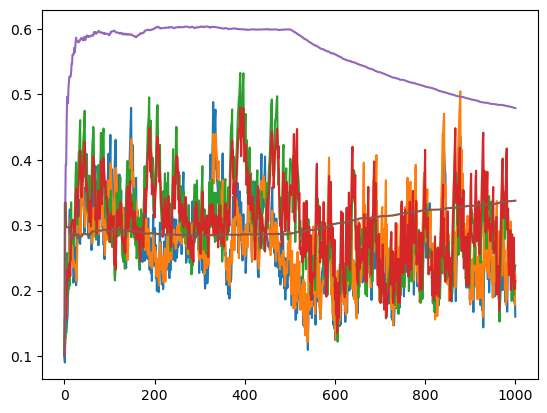

In [35]:
plt.plot(agentEWA1.Q_vals)
plt.plot(agentEWA2.Q_vals)
plt.plot(agentQ1.Q_vals)

(array([ 13.,  69., 147., 167., 129., 126., 176., 119.,  43.,  11.]),
 array([0.02079846, 0.10939058, 0.1979827 , 0.28657482, 0.37516693,
        0.46375905, 0.55235117, 0.64094328, 0.7295354 , 0.81812752,
        0.90671964]),
 <BarContainer object of 10 artists>)

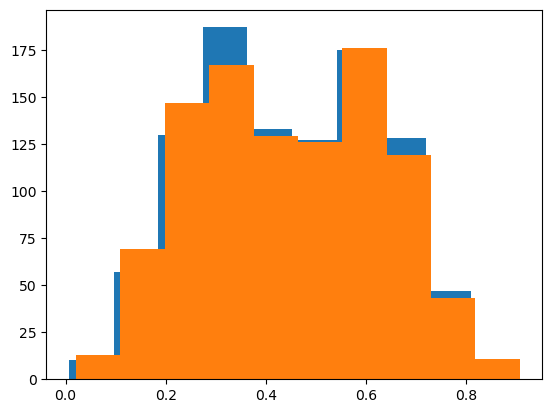

In [36]:
# plt.hist(agentEWA1.payoffs)
plt.hist(agentEWA2.payoffs)
plt.hist(agentQ1.payoffs)

In [32]:
print(np.mean(agentEWA2.correct), np.mean(agentQ1.correct) )

0.503 0.519


445.85830572468603 449.6065390190981


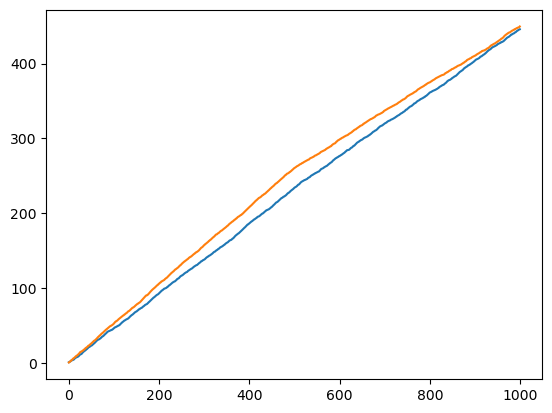

In [37]:
# plt.plot(np.cumsum(agentEWA1.payoffs))
plt.plot(np.cumsum(agentEWA2.payoffs))
plt.plot(np.cumsum(agentQ1.payoffs))

print(np.sum(agentEWA2.payoffs),np.sum(agentQ1.payoffs))